In [1]:
import pydpmd as dp
from pydpmd.plot import draw_particles_frame, create_animation, downsample, draw_circle
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import subprocess
from mode_resources import *
from system_building_resources import *
from matplotlib.colors import LogNorm
from scipy.special import j0

In [2]:
root = "/home/mmccraw/dev/data/11-15-25/jamming/disk/"
for fname in os.listdir(root):
    jam_data = dp.data.load(os.path.join(root, fname), location=['final', 'init'])
    # draw_particles_frame(None, plt.gca(), data, 20, True, 'particle', 'viridis', None)
    # plt.show()
    print(jam_data.packing_fraction[1])

0.8413476897478109
0.0
0.8414420315623289
0.8412857816815381
0.8411670255661016
0.8412178066968924
0.8394107817411425
0.8303176879286769
0.8412857816219333
0.8412734709382061
0.8413740567564971


In [121]:
H_list, M_list, val_list, vec_list, non_rattler_id_list = get_dynamical_matrix_modes_for_disk(jam_data, 3, True)

100%|██████████| 50/50 [00:08<00:00,  5.87it/s]


In [203]:
np.argwhere([np.sum(v < 0) == 0 for v in val_list])

array([[21],
       [39]])

In [185]:
temp_target = 1e-12
delta_phi = 1e-4

In [186]:
new_data = []
for non_rattler_ids, val, vec, d in zip(non_rattler_id_list, val_list, vec_list, split_systems(jam_data)):
    _d = Disk()
    _d.allocate_particles(len(non_rattler_ids))
    _d.allocate_systems(1)
    _d.pos = d.pos[non_rattler_ids]
    _d.rad = d.rad[non_rattler_ids]
    _d.mass = d.mass[non_rattler_ids]
    _d.e_interaction = d.e_interaction
    _d.box_size = d.box_size

    d = 2

    # m = get_eimask(val)
    m = val > 1e-10
    v = np.sum(vec[:, m], axis=1)
    N = len(val) // d
    v = np.column_stack((v[:N], v[N:2*N]))

    _d.vel = v
    ke = np.sum(0.5 * np.sum(_d.vel ** 2, axis=-1))
    temp = ke * 2 / (d * (N - 1))
    _d.vel *= np.sqrt(temp_target / temp)

    _d.set_ids()
    _d.validate()
    new_data.append(_d)
new_data = join_systems(new_data)
new_data.calculate_packing_fraction()

In [187]:
path = os.path.join(root, 'test')
# new_data.set_velocities(temp_target, np.random.randint(0, 1e9))
new_data.scale_to_packing_fraction(new_data.packing_fraction - delta_phi)
new_data.set_neighbor_method(NeighborMethod.Cell)
set_standard_cell_list_parameters(new_data, 0.3)
new_data.save(path)

subprocess.run([
    os.path.join("/home/mmccraw/dev/dpmd/build/", "nve_disk_pbc_final"),
    path,
    path,
    str(1e6),
    str(1e2),
    str(1e-2)
], check=True)

Running for 1000000 steps
Step 0
Step 10000
Step 20000
Step 30000
Step 40000
Step 50000
Step 60000
Step 70000
Step 80000
Step 90000
Step 100000
Step 110000
Step 120000
Step 130000
Step 140000
Step 150000
Step 160000
Step 170000
Step 180000
Step 190000
Step 200000
Step 210000
Step 220000
Step 230000
Step 240000
Step 250000
Step 260000
Step 270000
Step 280000
Step 290000
Step 300000
Step 310000
Step 320000
Step 330000
Step 340000
Step 350000
Step 360000
Step 370000
Step 380000
Step 390000
Step 400000
Step 410000
Step 420000
Step 430000
Step 440000
Step 450000
Step 460000
Step 470000
Step 480000
Step 490000
Step 500000
Step 510000
Step 520000
Step 530000
Step 540000
Step 550000
Step 560000
Step 570000
Step 580000
Step 590000
Step 600000
Step 610000
Step 620000
Step 630000
Step 640000
Step 650000
Step 660000
Step 670000
Step 680000
Step 690000
Step 700000
Step 710000
Step 720000
Step 730000
Step 740000
Step 750000
Step 760000
Step 770000
Step 780000
Step 790000
Step 800000
Step 810000
Step

CompletedProcess(args=['/home/mmccraw/dev/dpmd/build/nve_disk_pbc_final', '/home/mmccraw/dev/data/11-15-25/jamming/disk/test', '/home/mmccraw/dev/data/11-15-25/jamming/disk/test', '1000000.0', '100.0', '0.01'], returncode=0)

In [188]:
dynamics_data = dp.data.load(path, location=['final', 'init'], load_trajectory=True)

Loading trajectory: 100%|██████████| 7/7 [00:00<00:00, 16.20it/s]


In [189]:
desired_frames = 100
steps_to_animate = downsample(dynamics_data, desired_frames)

output_path = "anim.gif"

# Create the animation using the downsampled steps
create_animation(
    update_func=draw_particles_frame,
    frames=steps_to_animate,
    filename=output_path,
    fps=15,
    bitrate=3000,
    data=dynamics_data,
    system_id=5,
    use_pbc=True,
    which='particle',
    cmap_name='grey',
    id_scale=1.1
)

Creating animation:   6%|▌         | 6/100 [00:00<00:01, 48.71it/s]

Saving animation to anim.gif...


Creating animation: 101it [00:04, 23.68it/s]                        

Animation saved successfully!


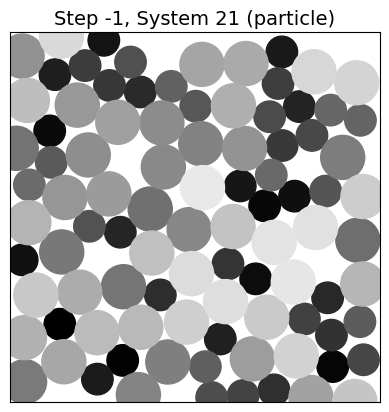

In [204]:
sid = 21
fid = -1
draw_particles_frame(fid, plt.gca(), dynamics_data, sid, True, 'particle', 'grey', 'trajectory', 1.1)
v = vec_list[sid].copy()

N = non_rattler_id_list[sid].size

# i = -1
# v_i = np.column_stack((v[:N, i], v[N:, i]))

# p = np.mod(data.pos[data.system_id == sid][non_rattler_id_list[sid]], data.box_size[sid])
# plt.quiver(p[:, 0], p[:, 1], v_i[:, 0], v_i[:, 1])

In [205]:
i0 = 1000
P = dynamics_data.trajectory.pos[i0:]
k = (2 * np.pi / (2 * dynamics_data.rad))
C = np.add.reduceat(j0(k * np.linalg.norm(P - P[0], axis=-1)), dynamics_data.system_offset[:-1], axis=1) / dynamics_data.system_size
U = np.add.reduceat(np.linalg.norm(P - np.mean(P, axis=0), axis=-1), dynamics_data.system_offset[:-1], axis=1) / dynamics_data.system_size

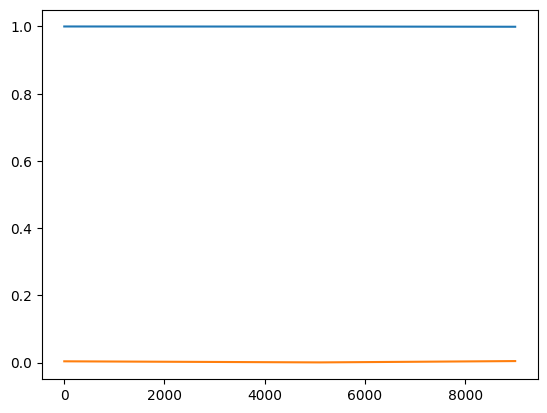

In [209]:
plt.plot(C[:, -1])
plt.plot(U[:, -1])

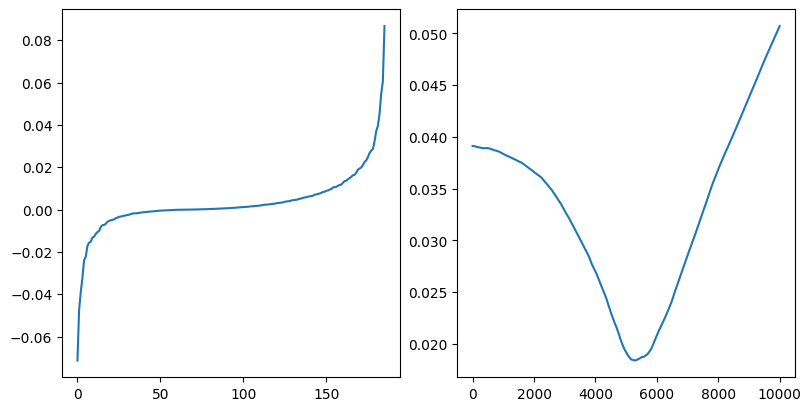

In [210]:
sid = 21
t0 = 0
tf = -1

P = dynamics_data.trajectory.pos[t0:tf, dynamics_data.system_id == sid]
V = dynamics_data.trajectory.vel[t0:tf, dynamics_data.system_id == sid]

U = P - np.mean(P, axis=0)
rmsd = np.sqrt(np.mean(np.linalg.norm(U, axis=-1), axis=1))

U = np.concatenate((U[..., 0], U[..., 1]), axis=1)
U = U.T @ U
V = np.concatenate((V[..., 0], V[..., 1]), axis=1)
V = V.T @ V
M = np.diag(np.concatenate([dynamics_data.mass[dynamics_data.system_id == sid] for i in range(2)]))

S_vals, Y_vecs, S_vecs = get_S_modes_from_matrices(M, U, V)

fig, ax = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True)
ax[0].plot(S_vals)
ax[1].plot(rmsd)


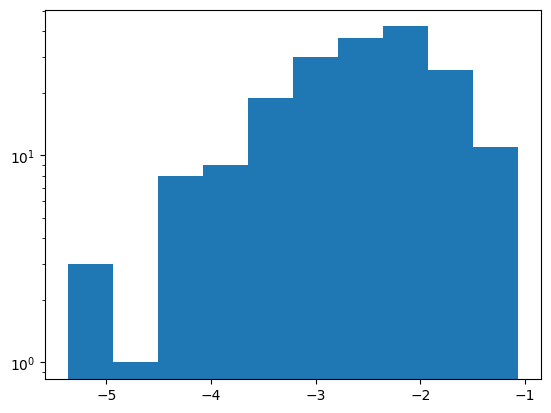

In [211]:
plt.hist(np.log10(np.abs(S_vals)))
plt.yscale('log')

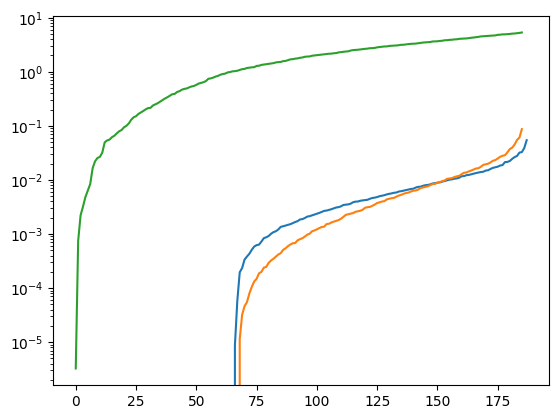

In [212]:
vals, vecs = np.linalg.eigh(V @ np.linalg.pinv(U))

plt.plot(vals)
plt.plot(S_vals)
plt.plot(val_list[sid][2:])
plt.yscale('log')